In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety()
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        if list(nearest_centroid).count(i+1) == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


SyntaxError: invalid syntax (<ipython-input-1-d13f994f74f9>, line 79)

In [2]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        if list(nearest_centroid).count(i+1) == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here


TypeError: 'int' object is not iterable

In [3]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        if list(nearest_centroid).count((i+1) == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


SyntaxError: invalid syntax (<ipython-input-3-12fe8ab4bb60>, line 83)

In [4]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        if list(nearest_centroid).count((i+1)) == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here


TypeError: 'int' object is not iterable

In [5]:
print(k)


5


In [6]:
print(i)


NameError: name 'i' is not defined

In [7]:
list(nearest_centroid).count(k)


TypeError: 'int' object is not iterable

In [8]:
list(nearest_centroid).count(3)




TypeError: 'int' object is not iterable

In [9]:
numpy.unique(nearest_centroid, return_counts=True)


NameError: name 'numpy' is not defined

In [10]:
np.unique(nearest_centroid, return_counts=True)


(array([0]), array([1], dtype=int64))

In [11]:
np.unique(nearest_centroid[:, 0], return_counts=True)

TypeError: 'int' object is not subscriptable

In [12]:
print(nearest_centroid)


0


In [13]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(i+1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here


TypeError: 'int' object is not iterable

In [14]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here


TypeError: 'int' object is not iterable

In [1]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here


TypeError: 'int' object is not iterable

In [2]:
print(nearest_centroid)


0


here
Runtime: 0:00:01.282665
kmeans centroids: [[155.40762329 215.80992126]
 [ 38.61558151 -74.45322418]
 [-41.51290512 -14.07450199]
 [-12.65969467  68.19604492]
 [167.94869995 -25.90857506]]
Runtime: 0:00:00.106738
sklearnkmeans centroids: [[-45.72084  -33.254642]
 [ 52.147728 -68.041916]
 [-21.425713  46.12709 ]
 [ 85.969444 173.40833 ]
 [174.54156  -25.316332]]


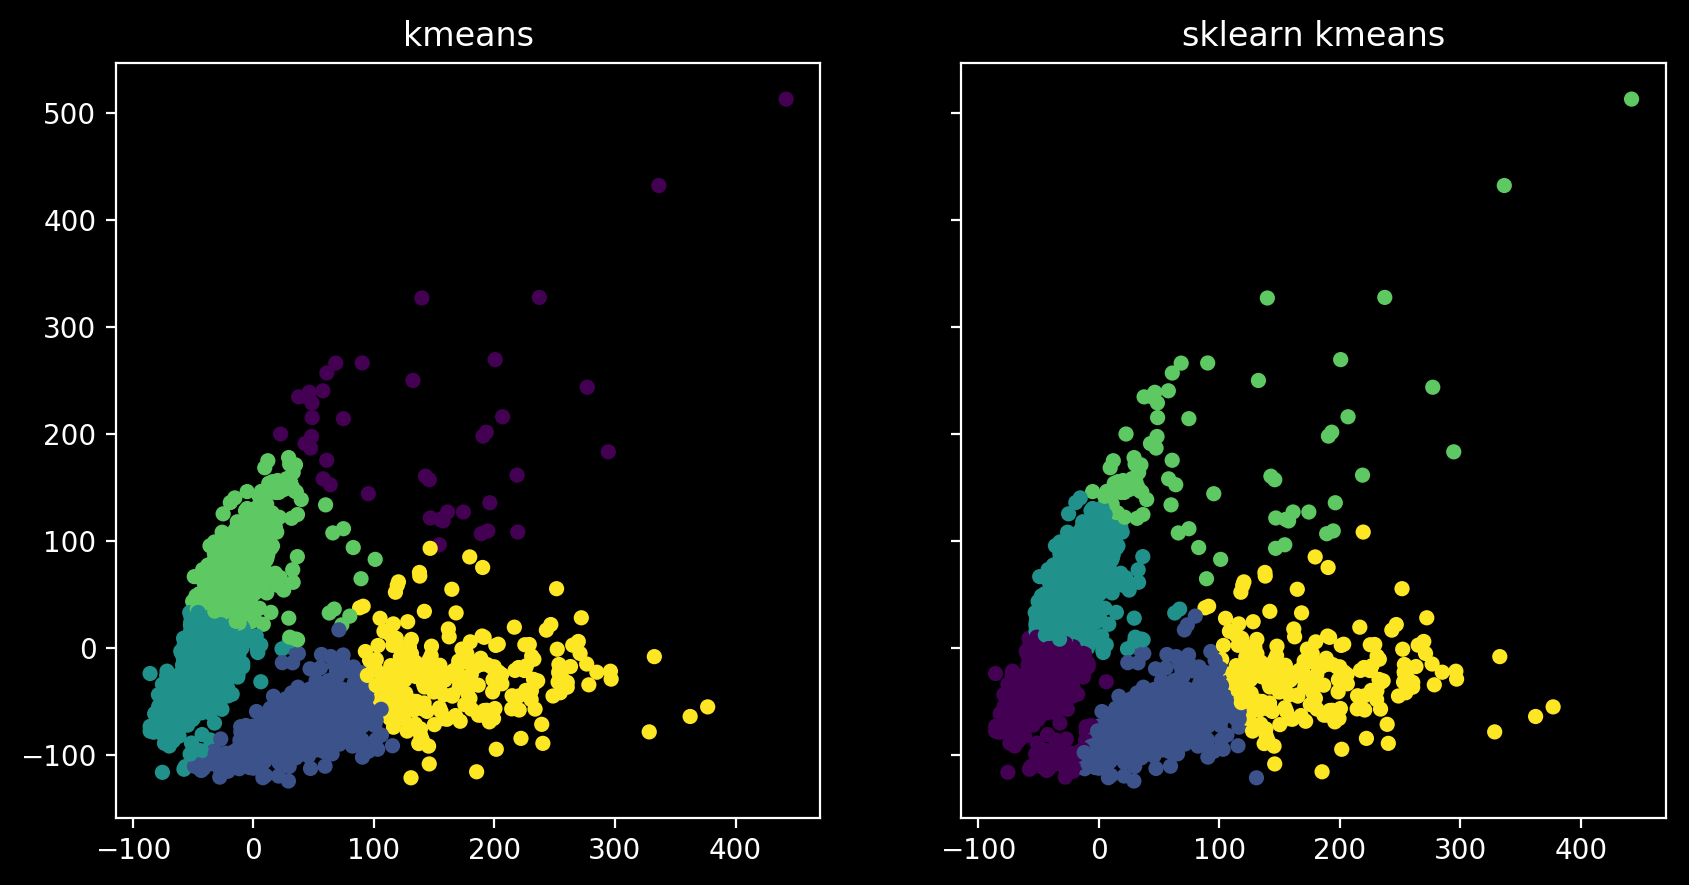

In [3]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        #safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

# def safety():
#     # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
#     i = 0
#     while i <= k:
#         s = list(nearest_centroid).count(1)
#         if s == 0:
#             random_start_centroids("rannumc")
#             print("Correcting centroids!")
#         else:
#             pass
#         i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Runtime: 0:00:01.051237
kmeans centroids: [[-36.13601303   3.79561543]
 [ 29.65108871 -77.51972961]
 [160.32595825 -25.70465279]
 [ 18.56200409 113.7796936 ]
 [         nan          nan]]
Runtime: 0:00:00.092754
sklearnkmeans centroids: [[-21.425697  46.12709 ]
 [ 52.147686 -68.04183 ]
 [-45.72084  -33.25464 ]
 [174.5415   -25.316408]
 [ 85.96946  173.40833 ]]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


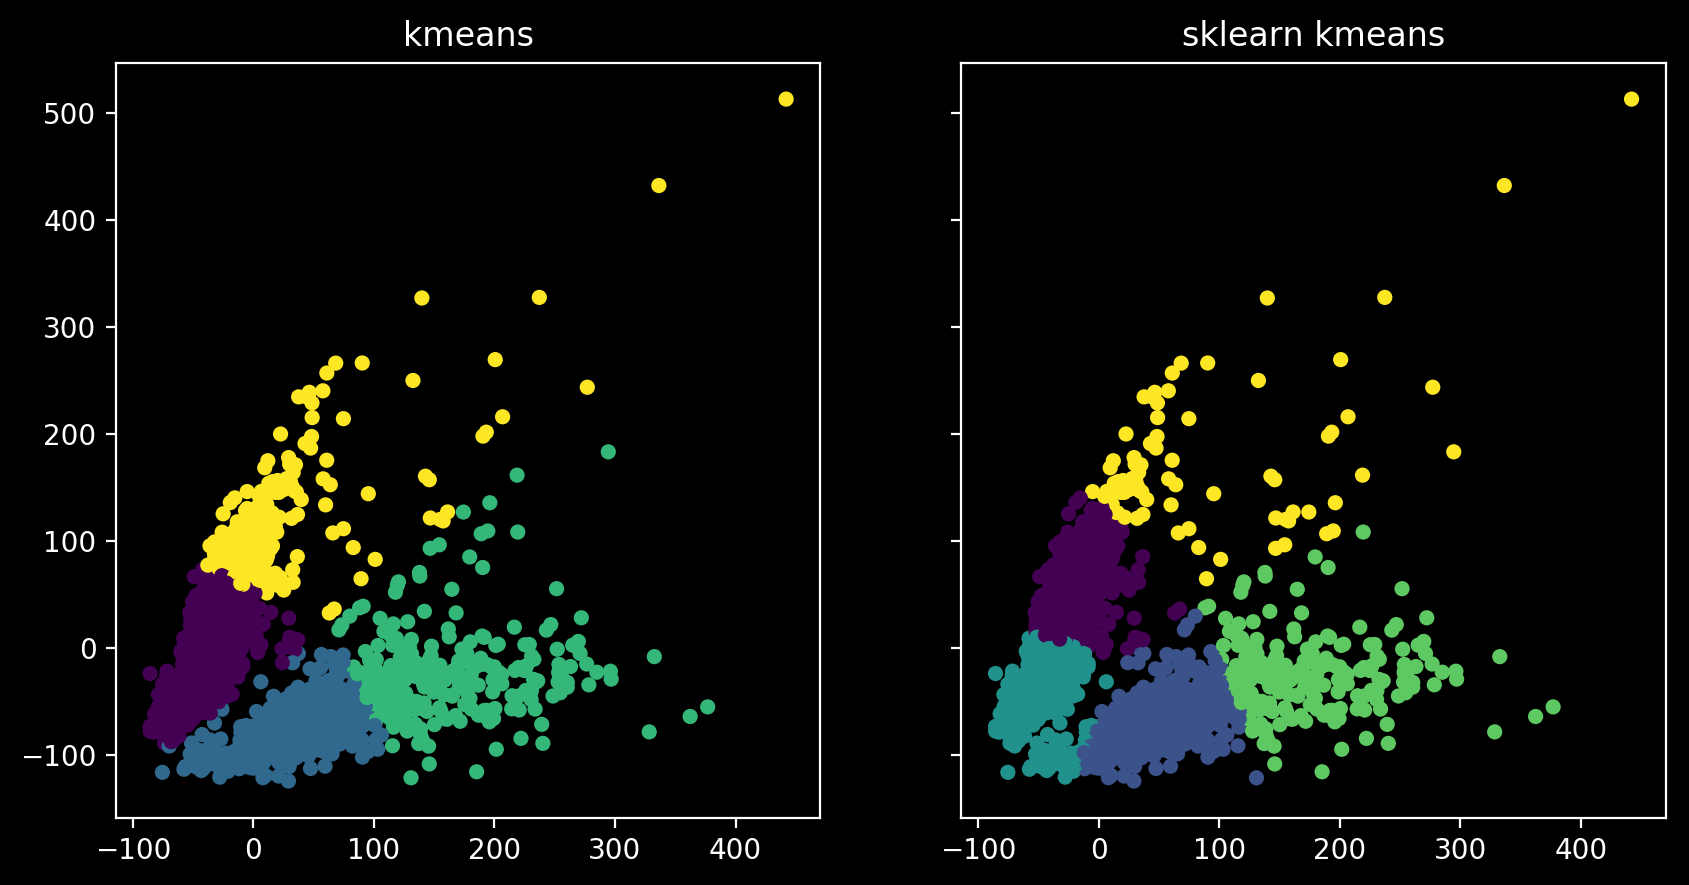

In [4]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        #safety()

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

# def safety():
#     # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
#     i = 0
#     while i <= k:
#         s = list(nearest_centroid).count(1)
#         if s == 0:
#             random_start_centroids("rannumc")
#             print("Correcting centroids!")
#         else:
#             pass
#         i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


In [5]:
print(nearest_centroid)


[[1.]
 [4.]
 [4.]
 ...
 [1.]
 [1.]
 [1.]]


here
Runtime: 0:00:01.391347
kmeans centroids: [[124.97389221 188.22338867]
 [122.35019684 -43.67400742]
 [         nan          nan]
 [-19.21201897  52.1936264 ]
 [-36.76844788 -36.2944603 ]]
Runtime: 0:00:00.108745
sklearnkmeans centroids: [[-21.425707  46.1271  ]
 [174.54155  -25.316387]
 [-45.720833 -33.254642]
 [ 52.14771  -68.041855]
 [ 85.96941  173.40834 ]]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


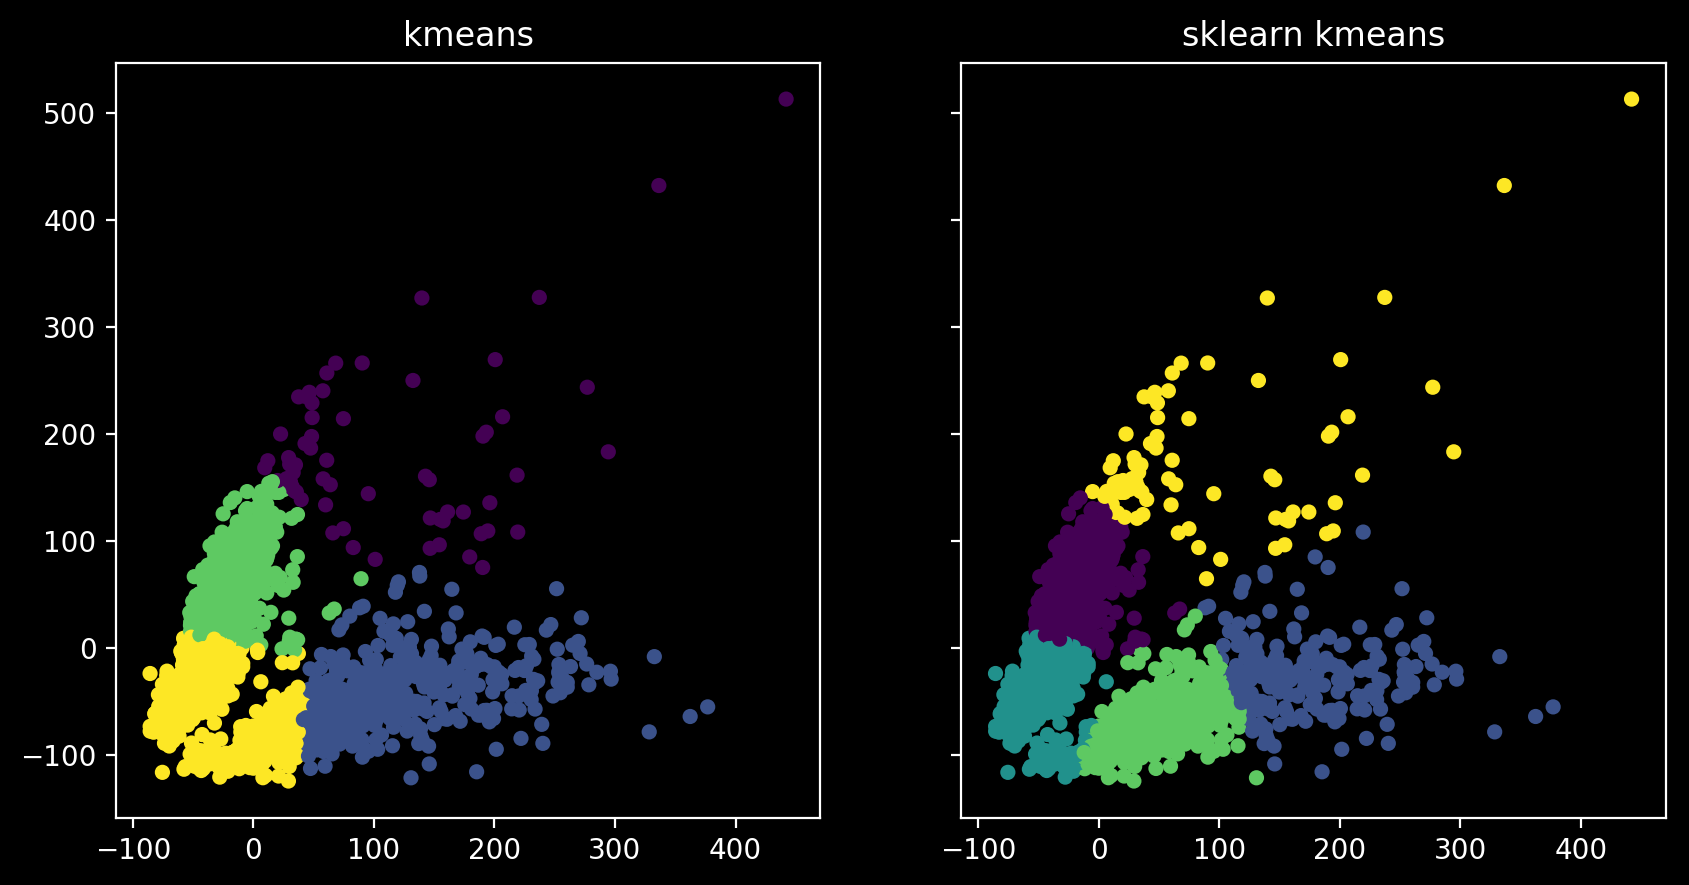

In [6]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Runtime: 0:00:01.388386
kmeans centroids: [[266.79260254 313.75656128]
 [122.80227661 -43.91086578]
 [ 64.90514374 149.69528198]
 [-37.04908752 -40.0741272 ]
 [-21.77399445  45.44062805]]
Runtime: 0:00:00.085810
sklearnkmeans centroids: [[-21.425707  46.12708 ]
 [ 52.14772  -68.041885]
 [174.54158  -25.316372]
 [-45.720848 -33.25463 ]
 [ 85.9695   173.40828 ]]


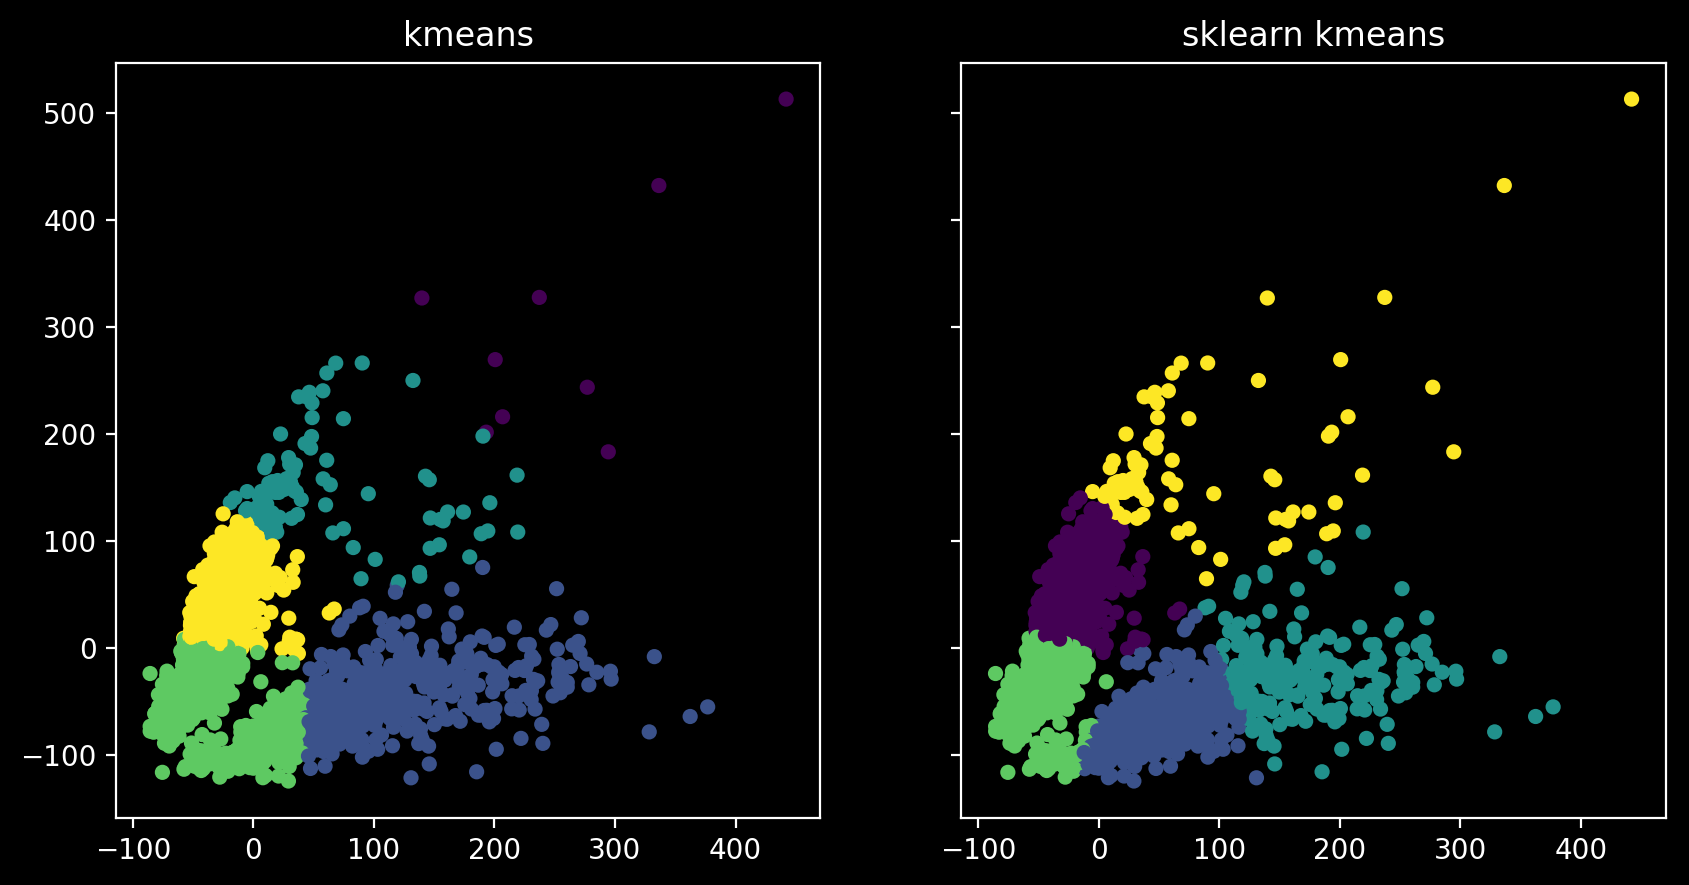

In [7]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()
        safety()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Runtime: 0:00:01.297598
kmeans centroids: [[190.61386108   3.90831208]
 [-42.17362976 -24.23056984]
 [ 62.57706451 -64.41279602]
 [-14.36724949  63.82432556]
 [         nan          nan]]
Runtime: 0:00:00.086764
sklearnkmeans centroids: [[-45.69877  -33.169636]
 [ 52.147736 -68.0419  ]
 [ 85.96942  173.40839 ]
 [174.54158  -25.316343]
 [-21.399658  46.200794]]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


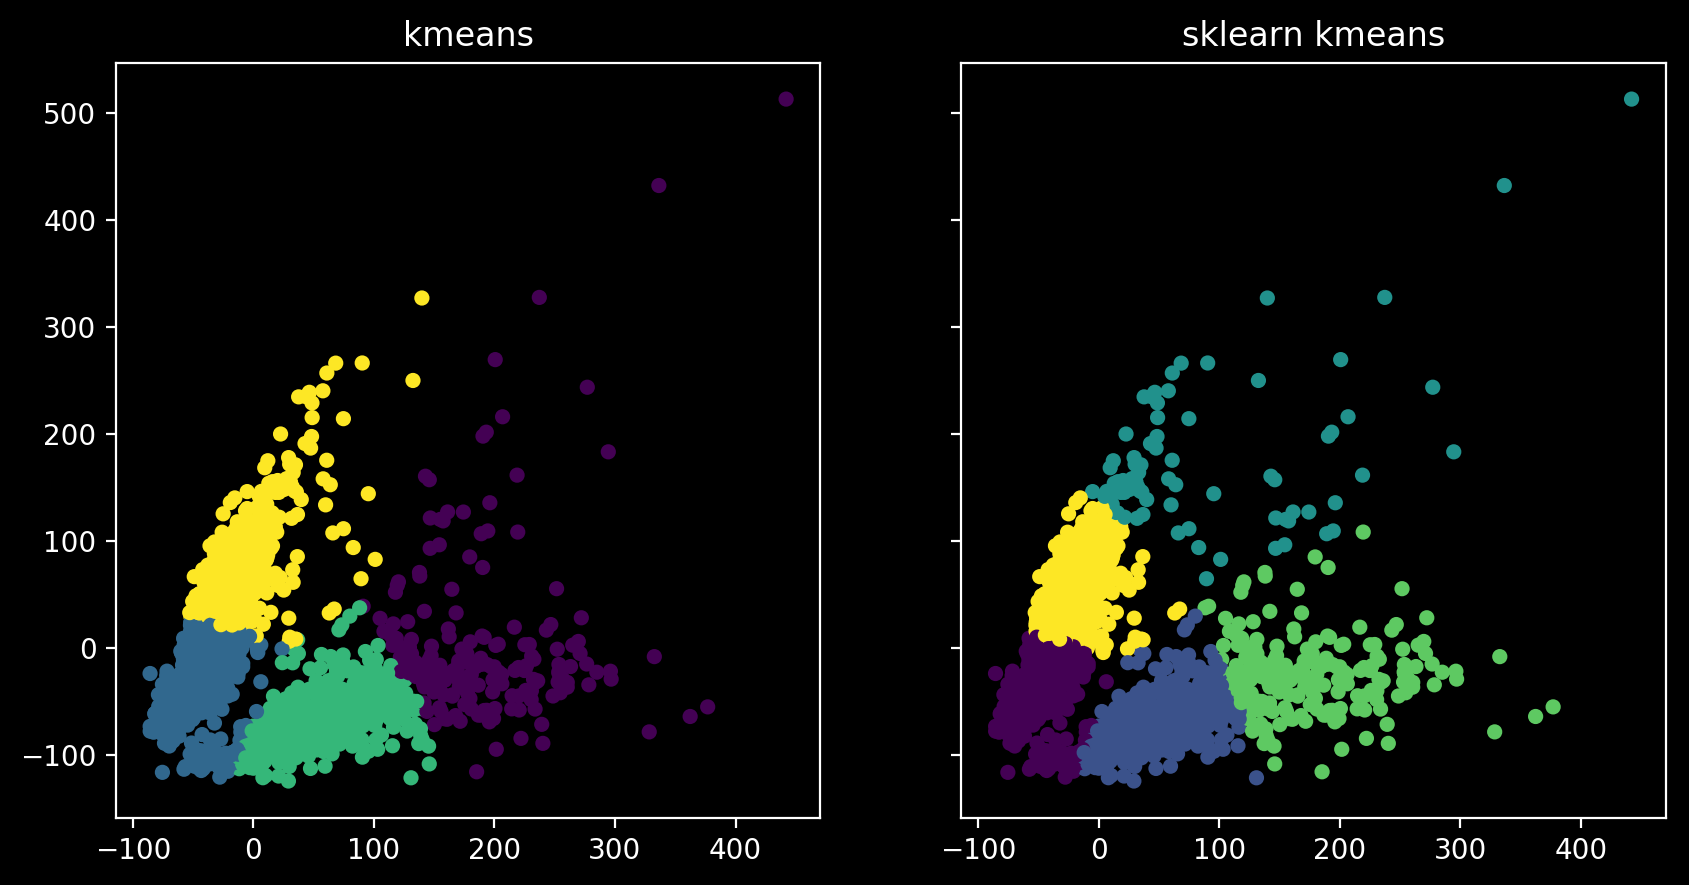

In [8]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()
        safety()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


In [9]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

    elif starttype == "rannumc":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])
        assign_centroids()
        safety()

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(i+1)
        if s == 0:
            random_start_centroids("rannumc")
            print("Correcting centroids!")
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


KeyboardInterrupt: 

In [10]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i <= k:
        s = list(nearest_centroid).count(i+1)
        if s == 0:
            print("Correcting centroids!")
            random_start_centroids("rannum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!
here
Correcting centroids!

KeyboardInterrupt: 

In [11]:
nearest_centroid


array([[4.],
       [1.],
       [1.],
       ...,
       [4.],
       [4.],
       [4.]])

In [12]:
list(nearest_centroid).count(1)




517

In [13]:
list(nearest_centroid).count(2)



5

In [14]:
list(nearest_centroid).count(3)


34

In [15]:
list(nearest_centroid).count(4)


1864

In [16]:
list(nearest_centroid).count(5)


280

here
Runtime: 0:00:01.223832
kmeans centroids: [[ 60.71323395 -64.32783508]
 [-19.83226967  50.62559891]
 [183.33610535 -23.84713936]
 [106.51816559 183.13735962]
 [-43.8525238  -31.49808884]]
Runtime: 0:00:00.083810
sklearnkmeans centroids: [[ 47.047962 -70.7755  ]
 [-21.224627  46.445667]
 [170.30908  -26.198587]
 [ 85.96937  173.40836 ]
 [-46.089497 -31.71116 ]]


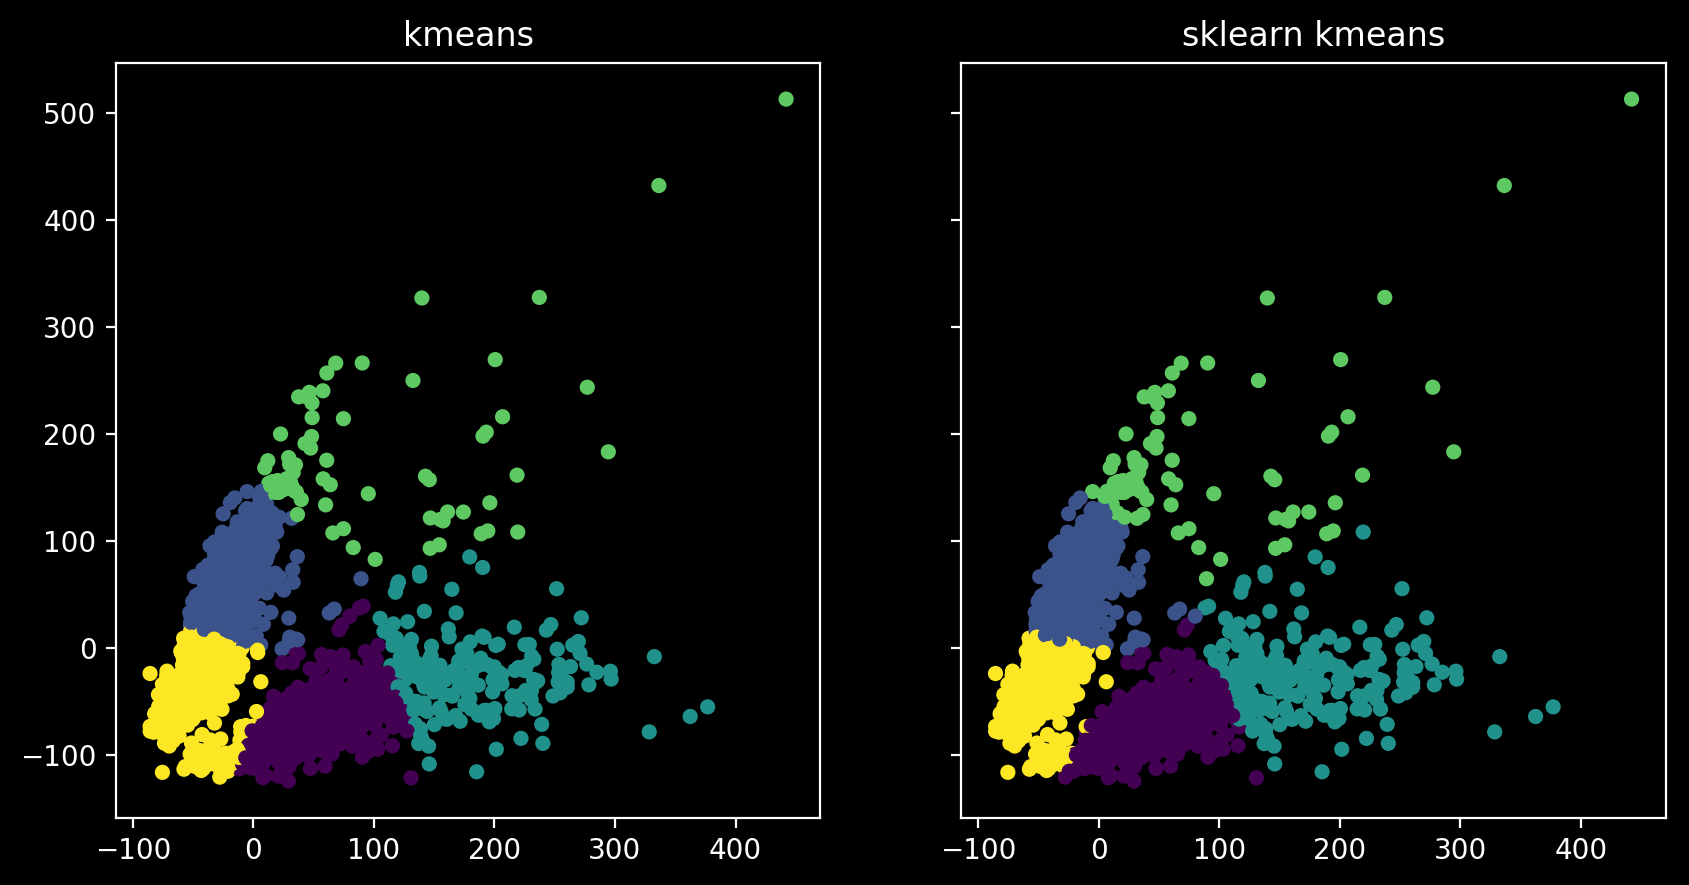

In [17]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        s = list(nearest_centroid).count(i+1)
        if s == 0:
            print("Correcting centroids!")
            random_start_centroids("rannum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Correcting centroids!
here
Runtime: 0:00:01.266686
kmeans centroids: [[-20.74997711  48.53619003]
 [338.52050781 423.98666382]
 [121.74512482 -44.2782135 ]
 [ 87.61437988 161.03442383]
 [-37.21316528 -37.81462097]]
Runtime: 0:00:00.088766
sklearnkmeans centroids: [[-45.720837 -33.254635]
 [-21.425688  46.1271  ]
 [174.54152  -25.316444]
 [ 85.96953  173.40833 ]
 [ 52.147663 -68.041855]]


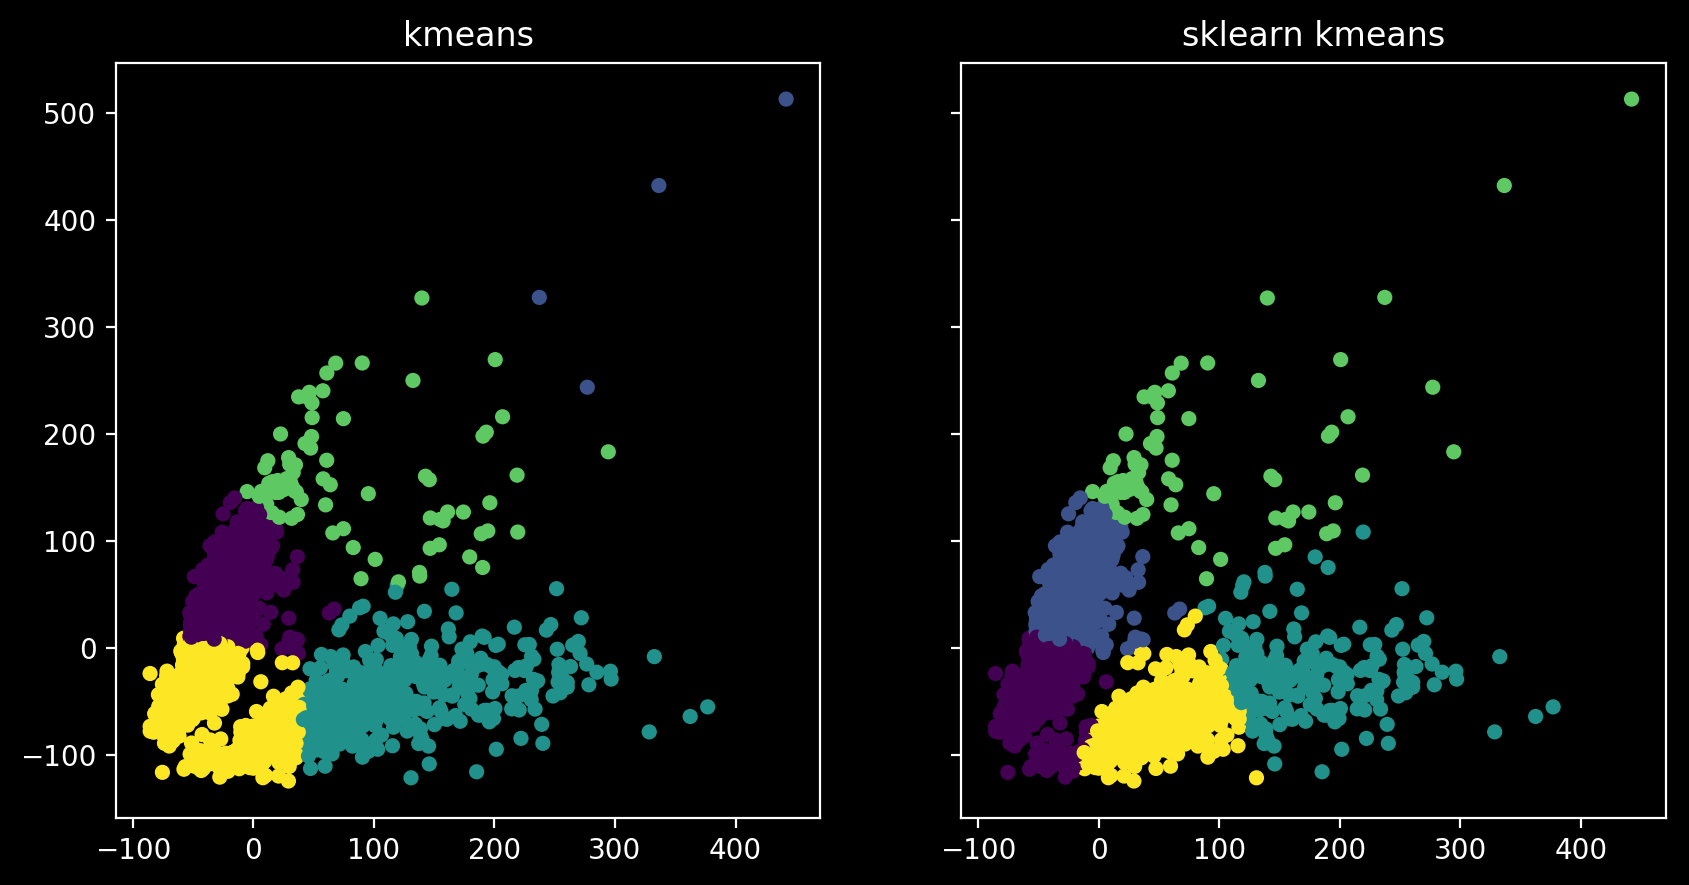

In [18]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        s = list(nearest_centroid).count(i+1)
        if s == 0:
            print("Correcting centroids!")
            random_start_centroids("rannum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


here
Correcting centroids!
here
Correcting centroids!
here
Runtime: 0:00:01.498050
kmeans centroids: [[-27.9163475  -66.36612701]
 [-34.95609665   4.05545664]
 [132.3523407  -39.38809967]
 [-11.74445534  71.1548996 ]
 [133.41120911 196.51631165]]
Runtime: 0:00:00.108714
sklearnkmeans centroids: [[-21.425709  46.127087]
 [ 52.147713 -68.04183 ]
 [-45.72084  -33.254642]
 [ 85.96942  173.40834 ]
 [174.54152  -25.31637 ]]


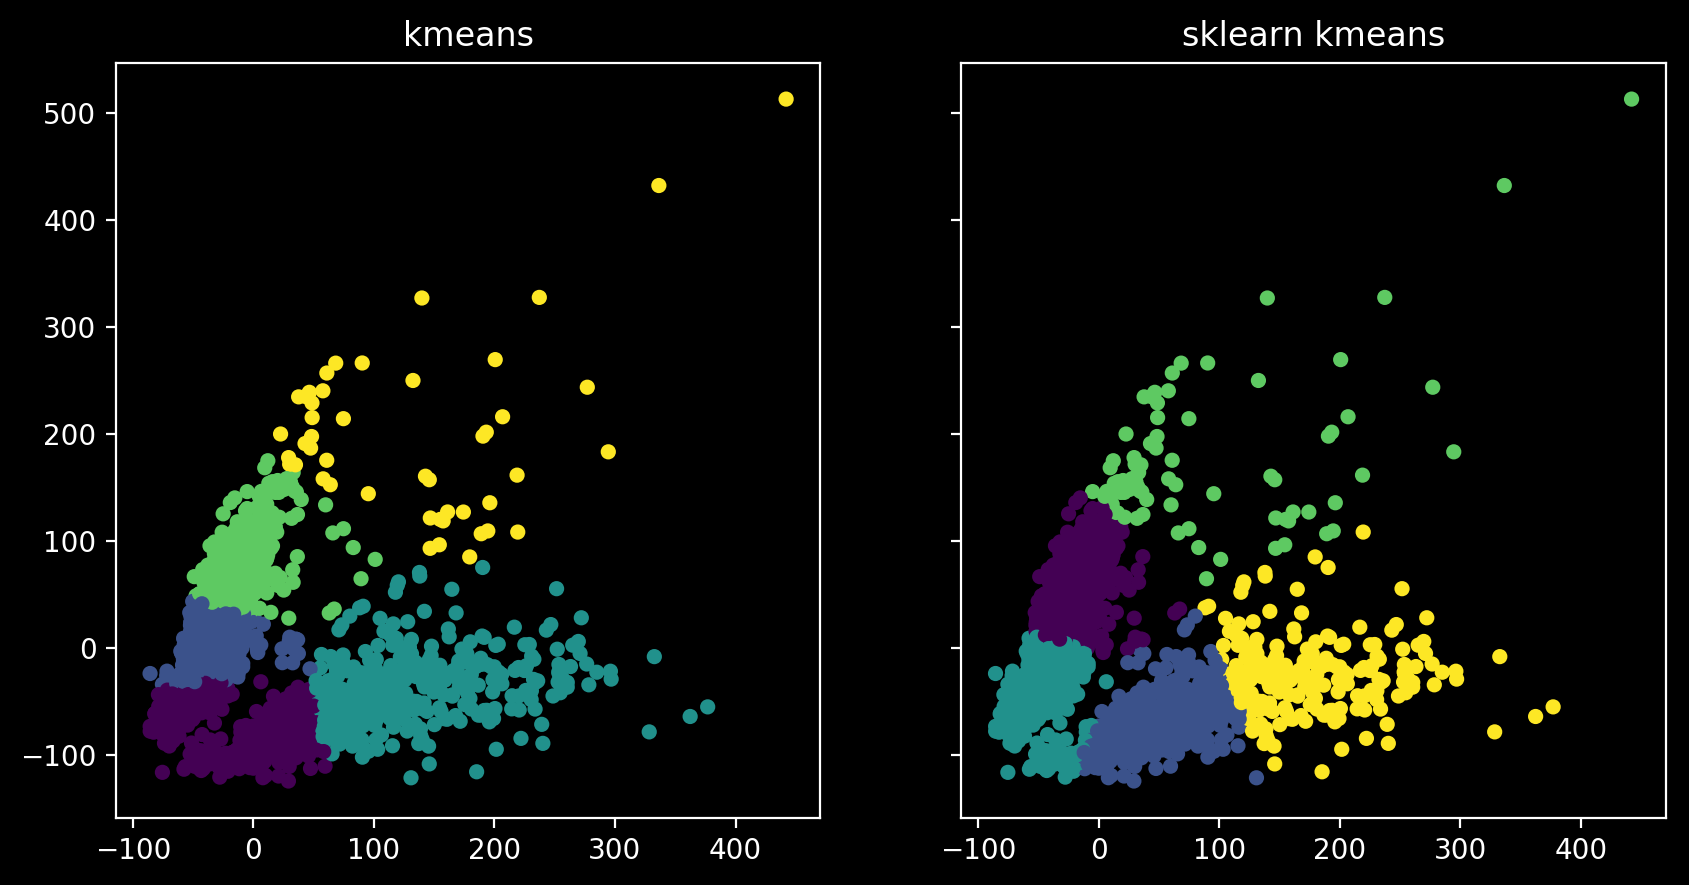

In [19]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])
    print("here")

    if starttype == "ranpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "rannum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Correcting centroids!")
            random_start_centroids("rannum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("rannum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Correcting centroids!
Runtime: 0:00:01.237782
kmeans centroids: [[-28.58835602  25.21371078]
 [180.15432739 200.80621338]
 [129.50344849 -40.54444885]
 [  1.13776207  98.07839966]
 [-33.96776962 -52.38357544]]
Runtime: 0:00:00.111708
sklearnkmeans centroids: [[-20.6786    47.9218  ]
 [170.06166  -26.324226]
 [-45.69916  -30.343853]
 [ 46.52558  -70.98865 ]
 [ 89.78511  177.08182 ]]


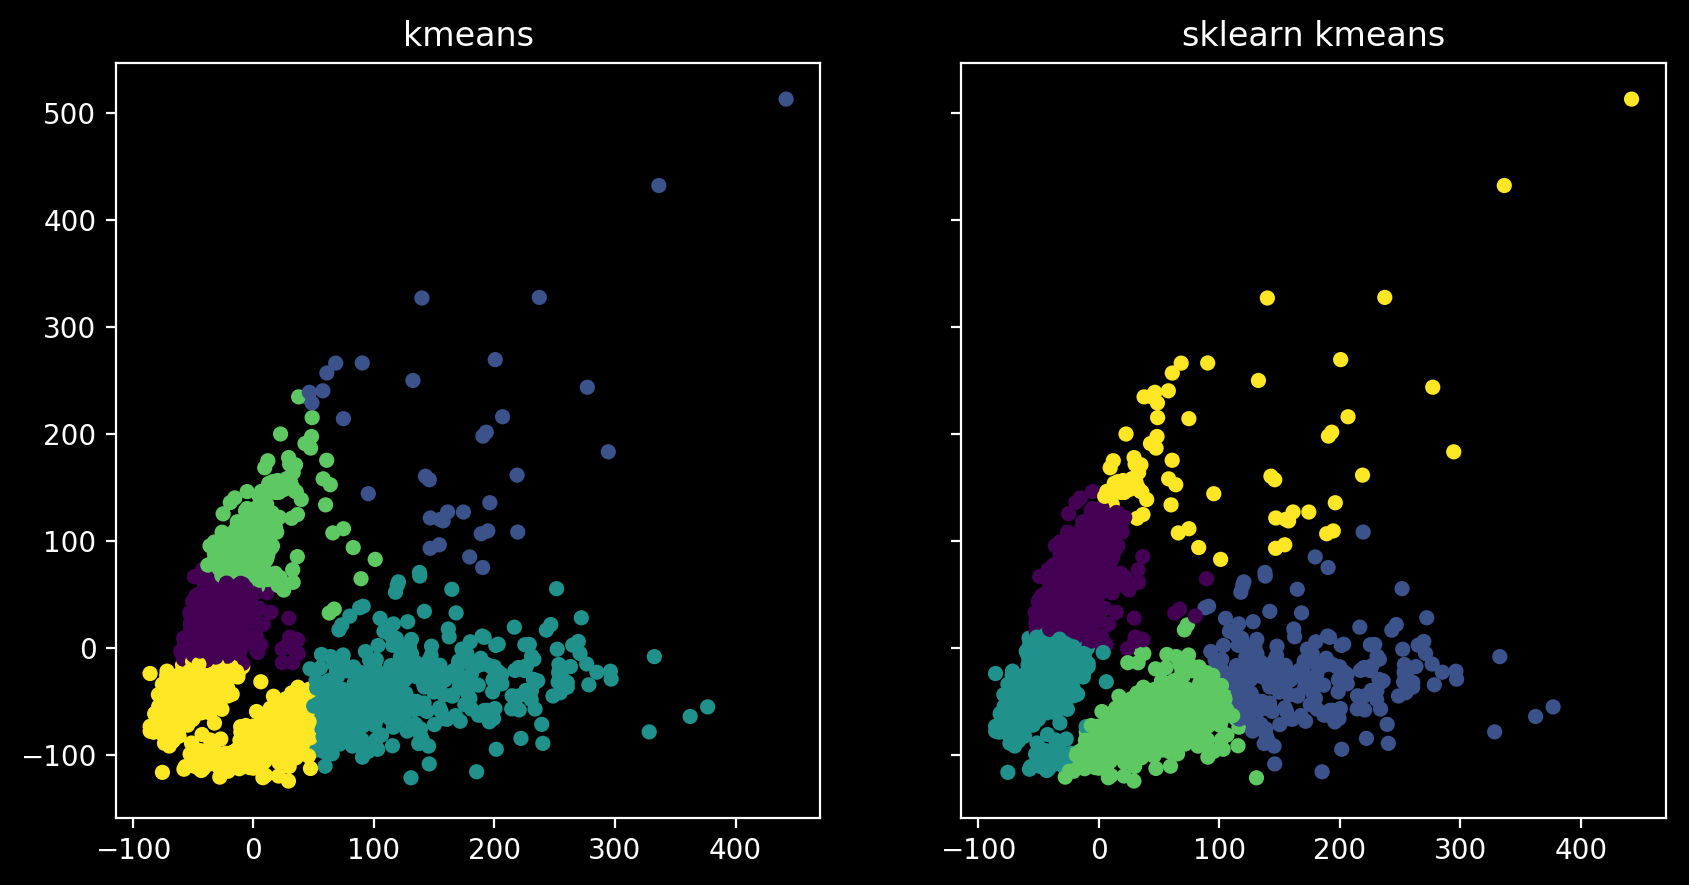

In [20]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Correcting centroids!")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.147019
kmeans centroids: [[-16.37088394  58.9607048 ]
 [ 72.92433929 -58.69519806]
 [197.57290649 -12.91783619]
 [155.63703918 251.29612732]
 [-41.13779831 -28.19131279]]
Runtime: 0:00:00.082783
sklearnkmeans centroids: [[-45.72084  -33.254646]
 [174.54149  -25.31638 ]
 [ 52.147686 -68.0419  ]
 [ 85.96947  173.40834 ]
 [-21.425695  46.1271  ]]


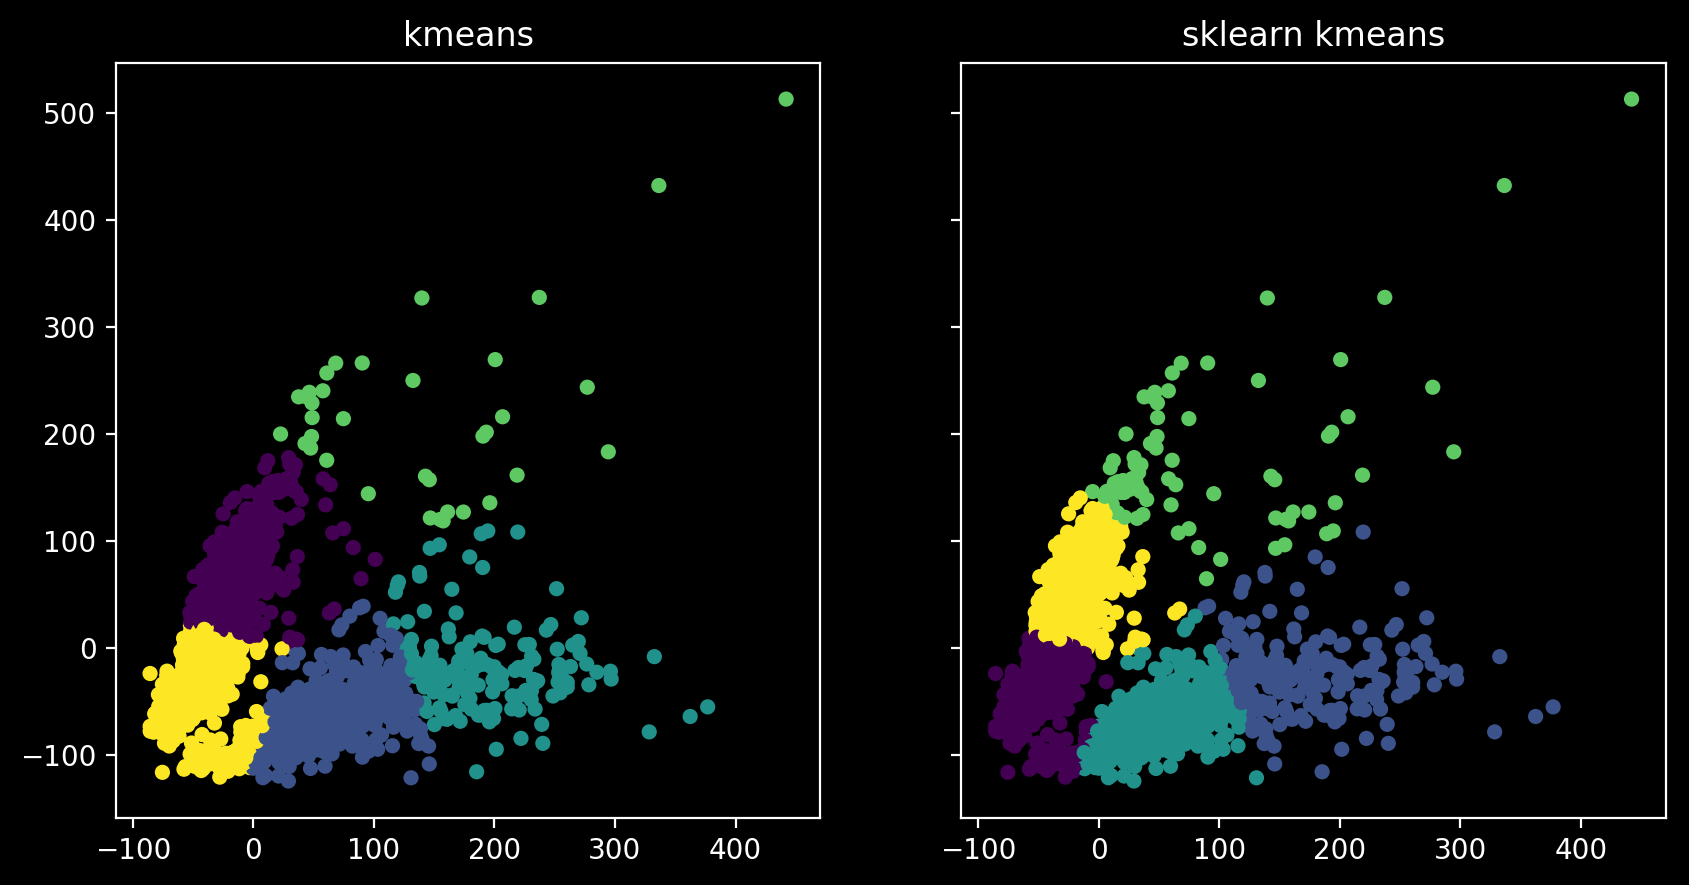

In [21]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.004333
kmeans centroids: [[-42.19989014 -27.46176529]
 [ 65.27711487 -62.34178162]
 [-16.51908302  58.43968201]
 [188.89289856 -17.34392929]
 [153.86538696 232.35906982]]
Runtime: 0:00:00.099765
sklearnkmeans centroids: [[ 85.96945  173.40834 ]
 [-45.72084  -33.25465 ]
 [-21.425709  46.127094]
 [ 52.147713 -68.04184 ]
 [174.54155  -25.316362]]


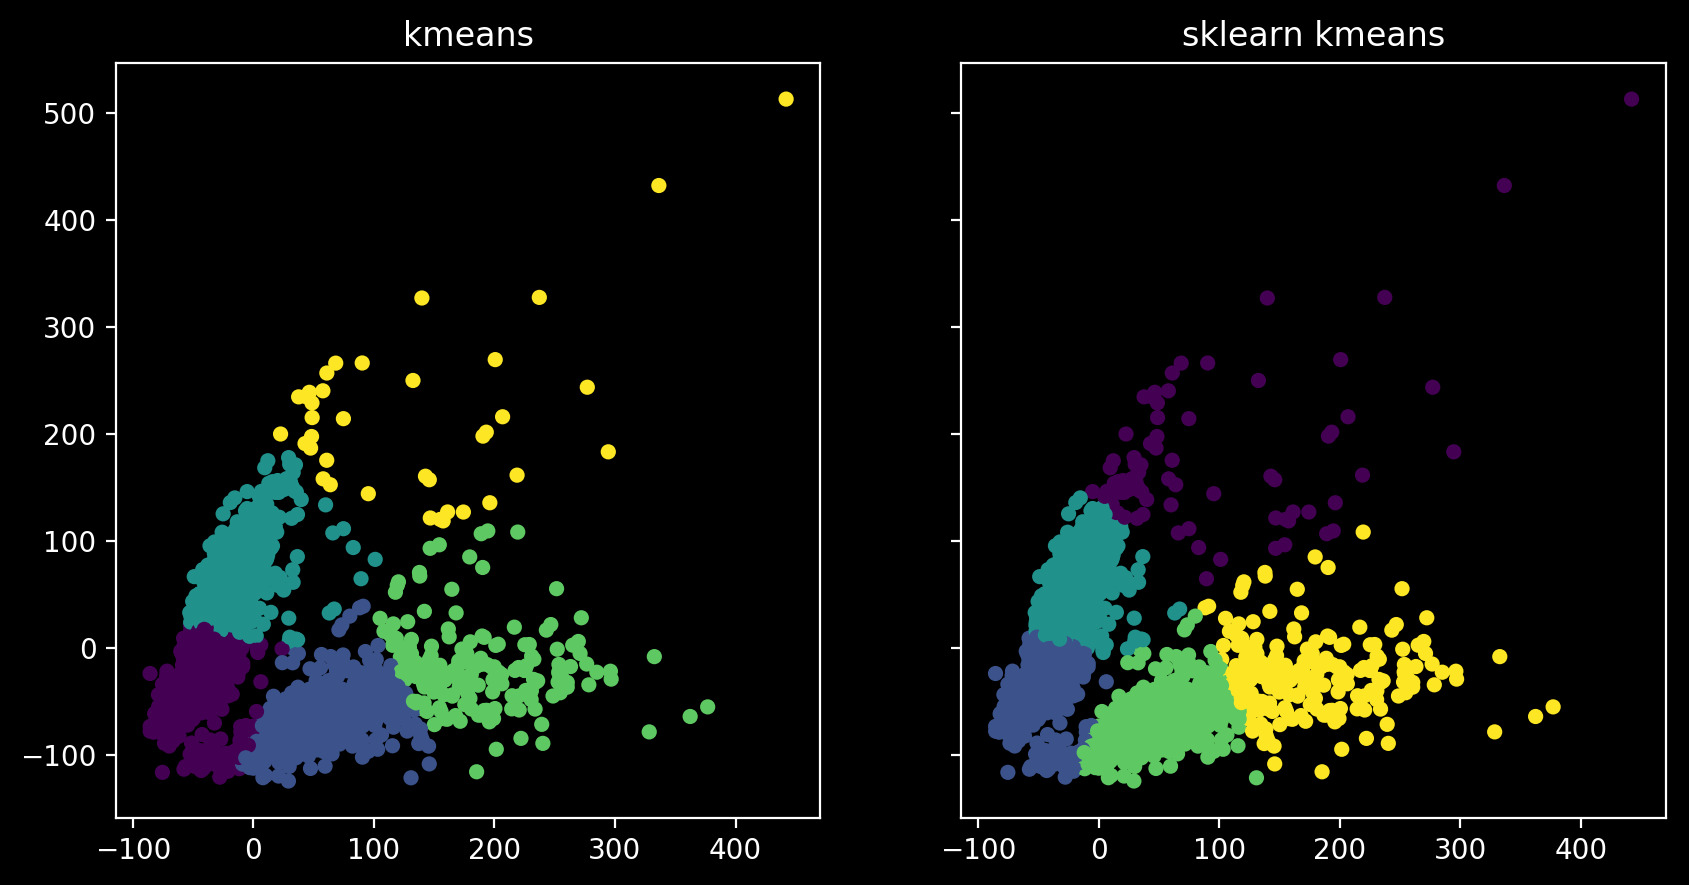

In [22]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:00.972448
kmeans centroids: [[-36.93969727 -39.40699768]
 [122.82636261 -43.92019272]
 [338.52026367 423.98672485]
 [ 84.86250305 159.92932129]
 [-21.22622108  47.00216675]]
Runtime: 0:00:00.078817
sklearnkmeans centroids: [[ 52.147736 -68.04185 ]
 [-21.425713  46.12709 ]
 [174.54155  -25.316357]
 [-45.720837 -33.254646]
 [ 85.96941  173.40834 ]]


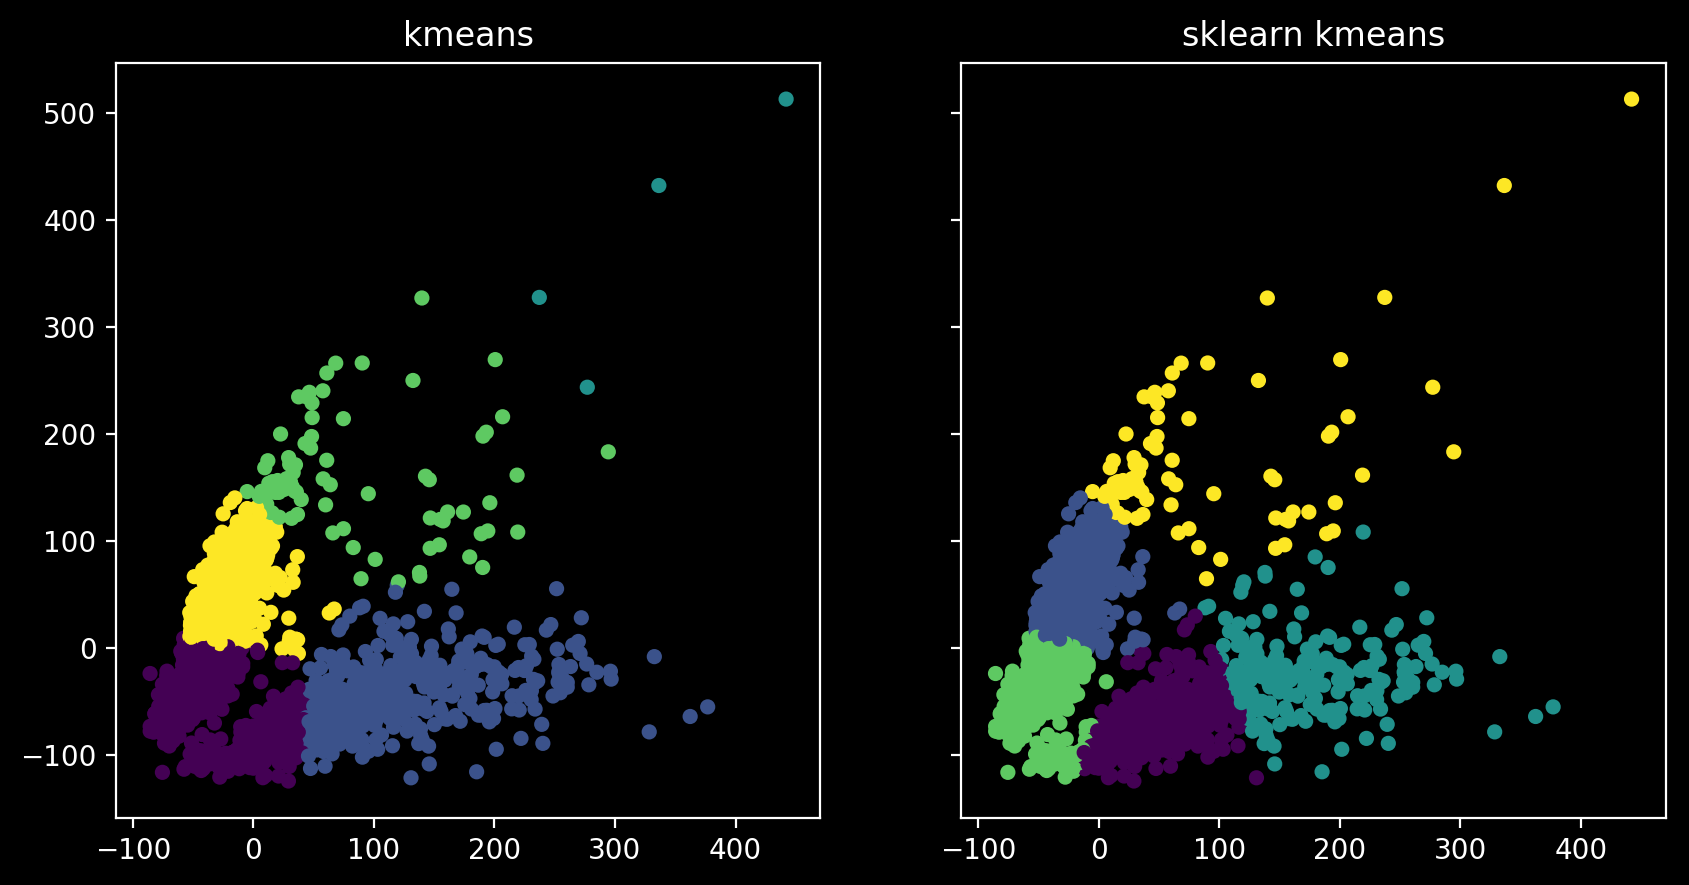

In [23]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.243768
kmeans centroids: [[170.42950439 -26.8654995 ]
 [ 44.4428215  -71.83956909]
 [130.36090088 198.16090393]
 [-16.77970505  58.24558258]
 [-43.53816605 -22.27648163]]
Runtime: 0:00:00.082802
sklearnkmeans centroids: [[-45.72084  -33.254623]
 [-21.42569   46.127083]
 [174.54152  -25.31637 ]
 [ 52.14769  -68.04189 ]
 [ 85.969475 173.40825 ]]


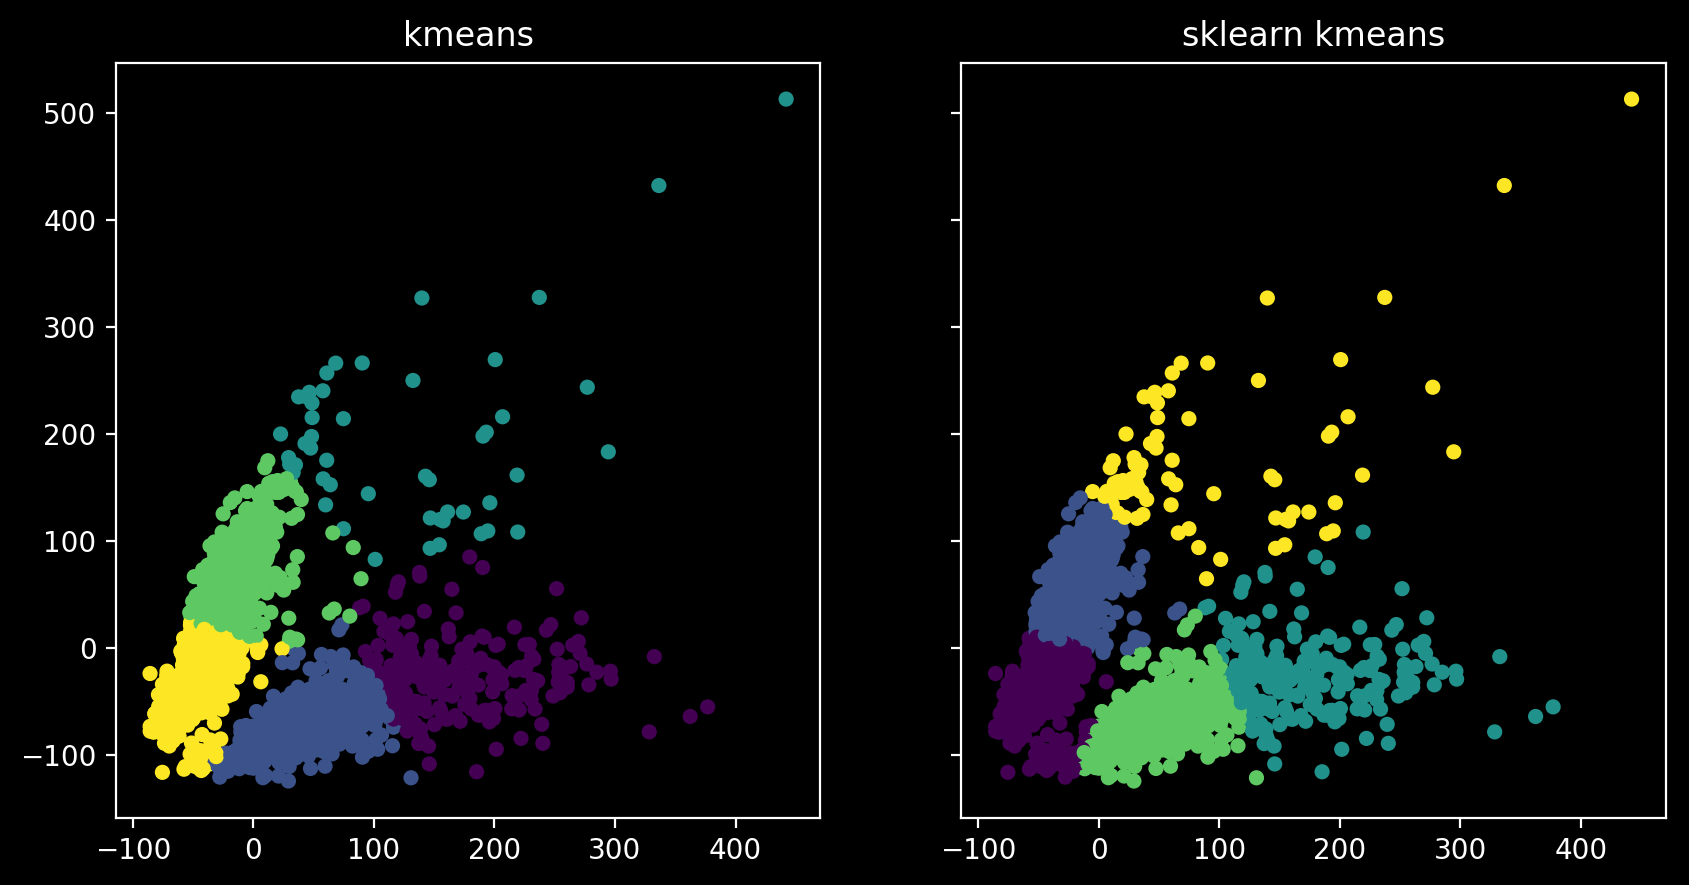

In [24]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.032292
kmeans centroids: [[-44.31174469 -38.81379318]
 [-22.27725792  43.7859993 ]
 [ 85.96952057 173.40827942]
 [ 66.79292297 -61.25872803]
 [189.18544006 -22.40830994]]
Runtime: 0:00:00.078790
sklearnkmeans centroids: [[-21.425682  46.12709 ]
 [174.54155  -25.3164  ]
 [-45.720848 -33.254627]
 [ 52.14768  -68.04191 ]
 [ 85.96952  173.4083  ]]


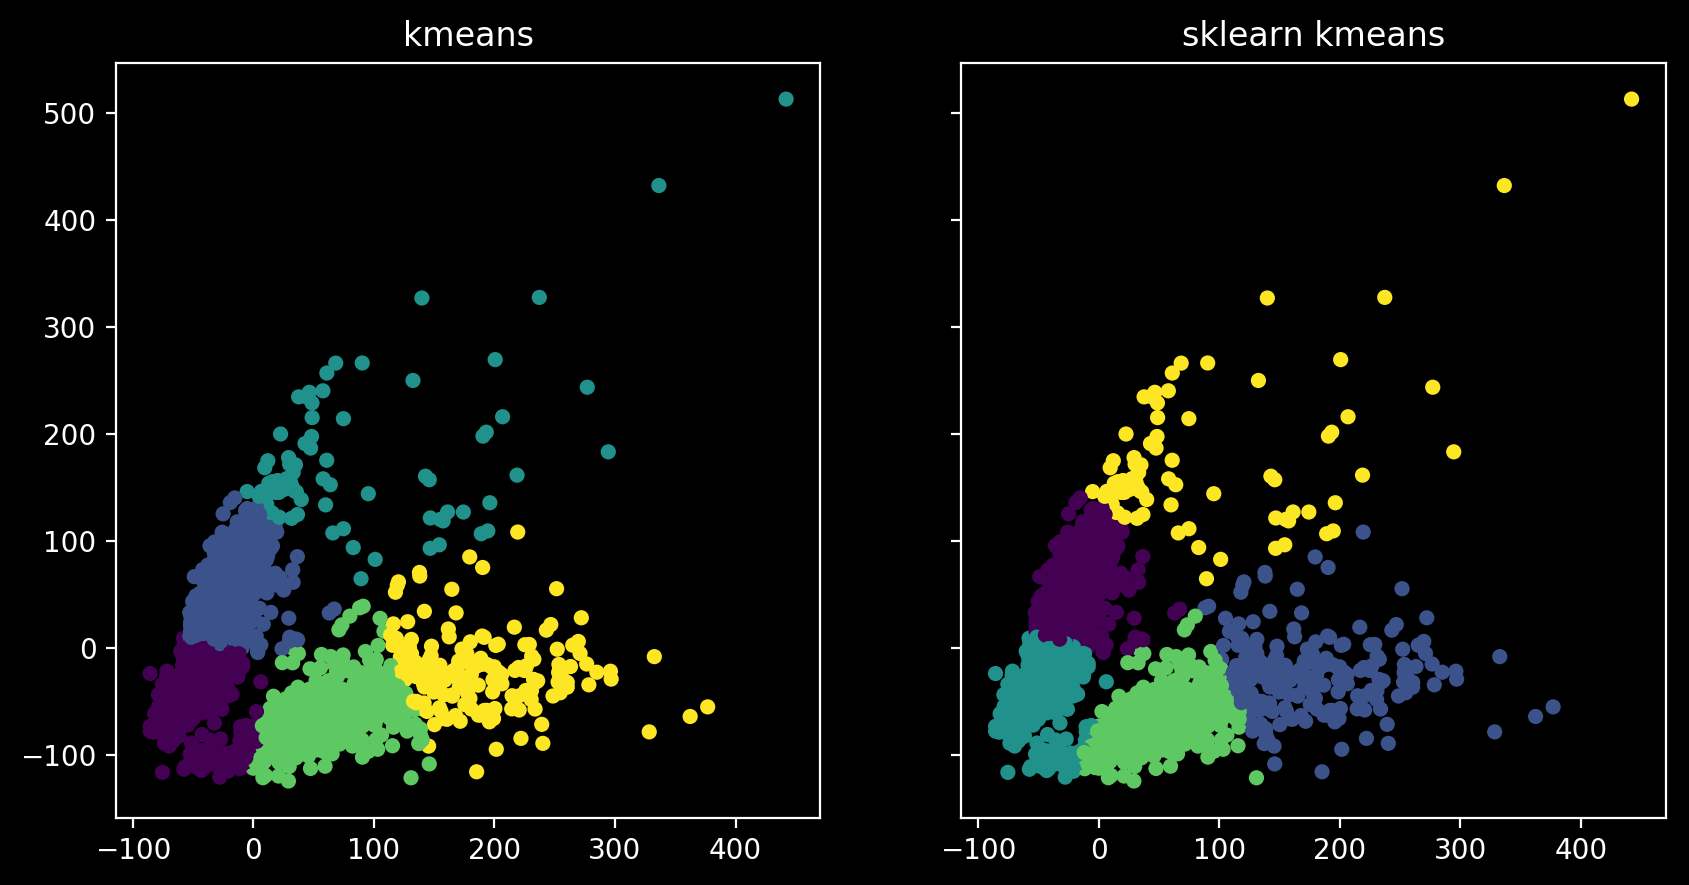

In [25]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Runtime: 0:00:01.350500
kmeans centroids: [[-44.82553101 -36.27123642]
 [ 85.96938324 173.40838623]
 [ 59.86628342 -64.26377106]
 [-21.90338898  45.04756546]
 [181.23320007 -24.33286667]]
Runtime: 0:00:00.082782
sklearnkmeans centroids: [[-21.425714  46.127098]
 [174.54155  -25.31635 ]
 [ 52.147728 -68.04183 ]
 [-45.720818 -33.254665]
 [ 85.9694   173.40839 ]]


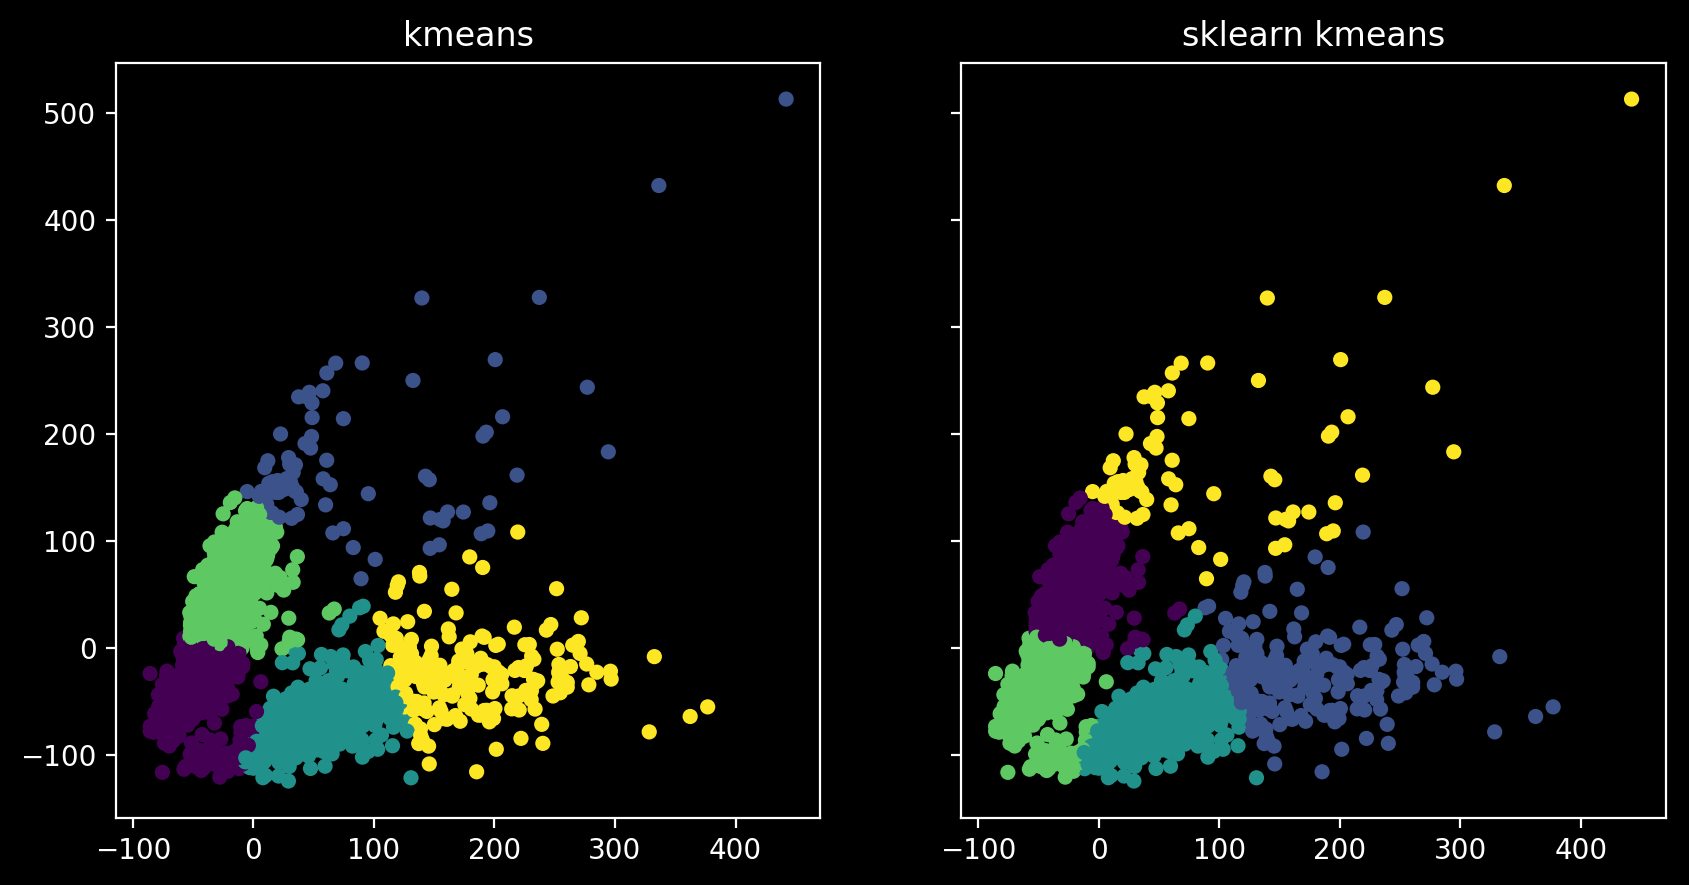

In [26]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def safety():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            safety()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        safety()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.013388
kmeans centroids: [[-36.87062454 -39.24884796]
 [ 84.8625412  159.92936707]
 [338.52035522 423.98681641]
 [-21.23980522  47.1635704 ]
 [122.82635498 -43.92019653]]
Runtime: 0:00:00.078792
sklearnkmeans centroids: [[-21.425709  46.127106]
 [ 52.14771  -68.0419  ]
 [174.54156  -25.31632 ]
 [-45.72084  -33.254658]
 [ 85.969444 173.40839 ]]


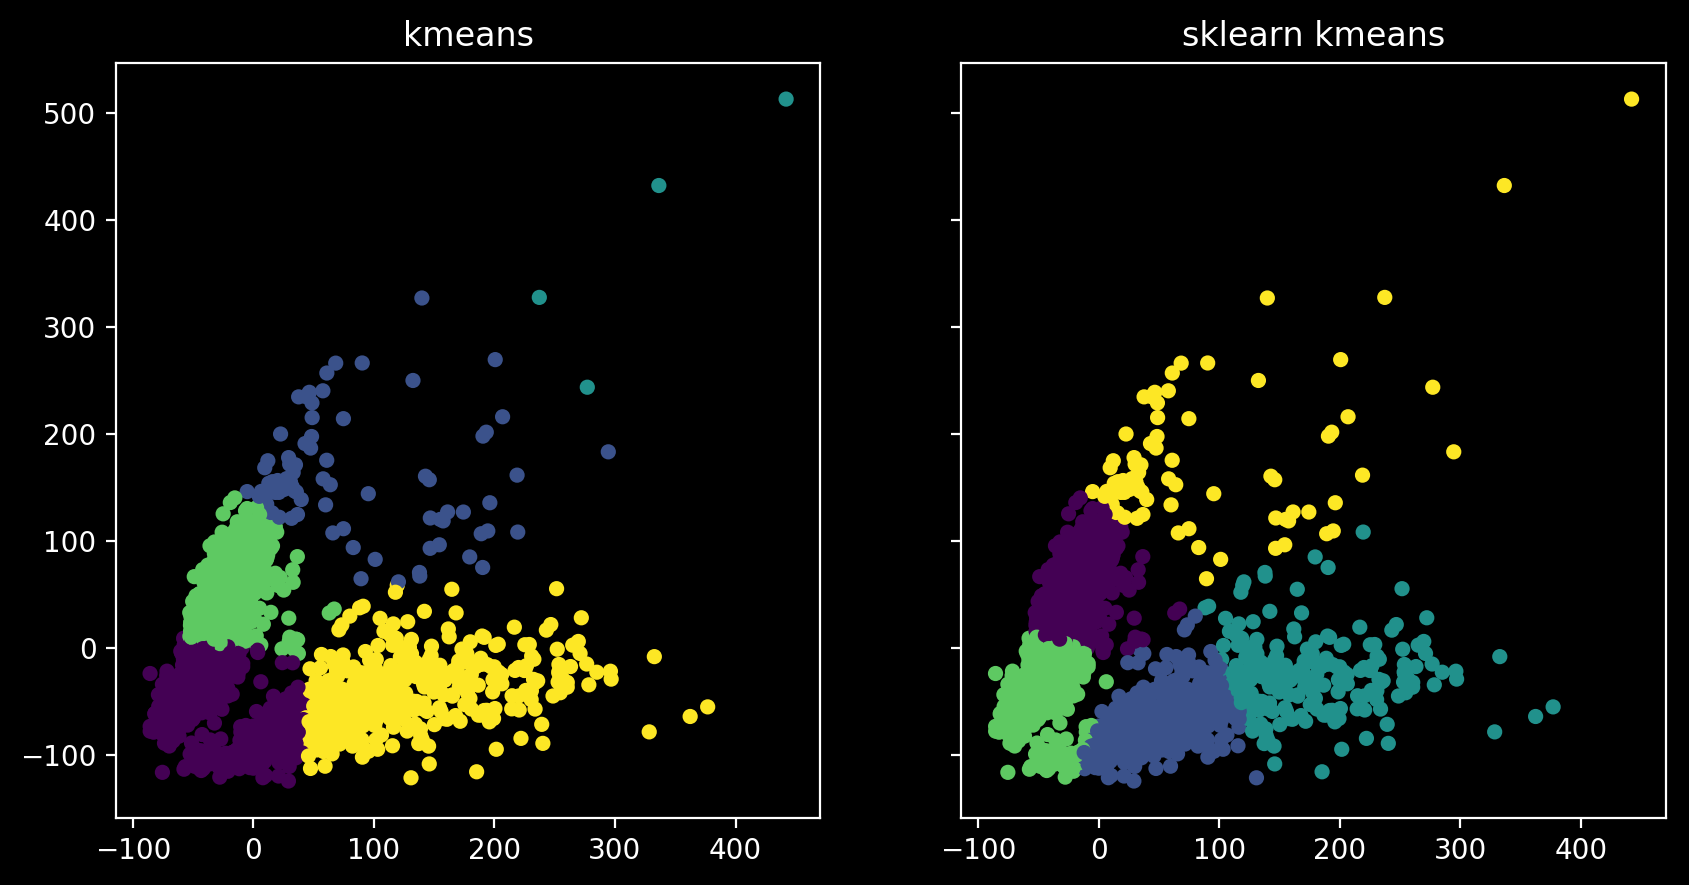

In [27]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        empty_check()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Runtime: 0:00:01.297597
kmeans centroids: [[149.88198853 198.68518066]
 [ -7.15964556  81.72705841]
 [-32.62726593 -57.46526718]
 [130.11624146 -40.50179291]
 [-31.4367485   15.42044163]]
Runtime: 0:00:00.089765
sklearnkmeans centroids: [[-45.720844 -33.254642]
 [ 52.14768  -68.04191 ]
 [-21.42569   46.127094]
 [174.5415   -25.316399]
 [ 85.969475 173.40831 ]]


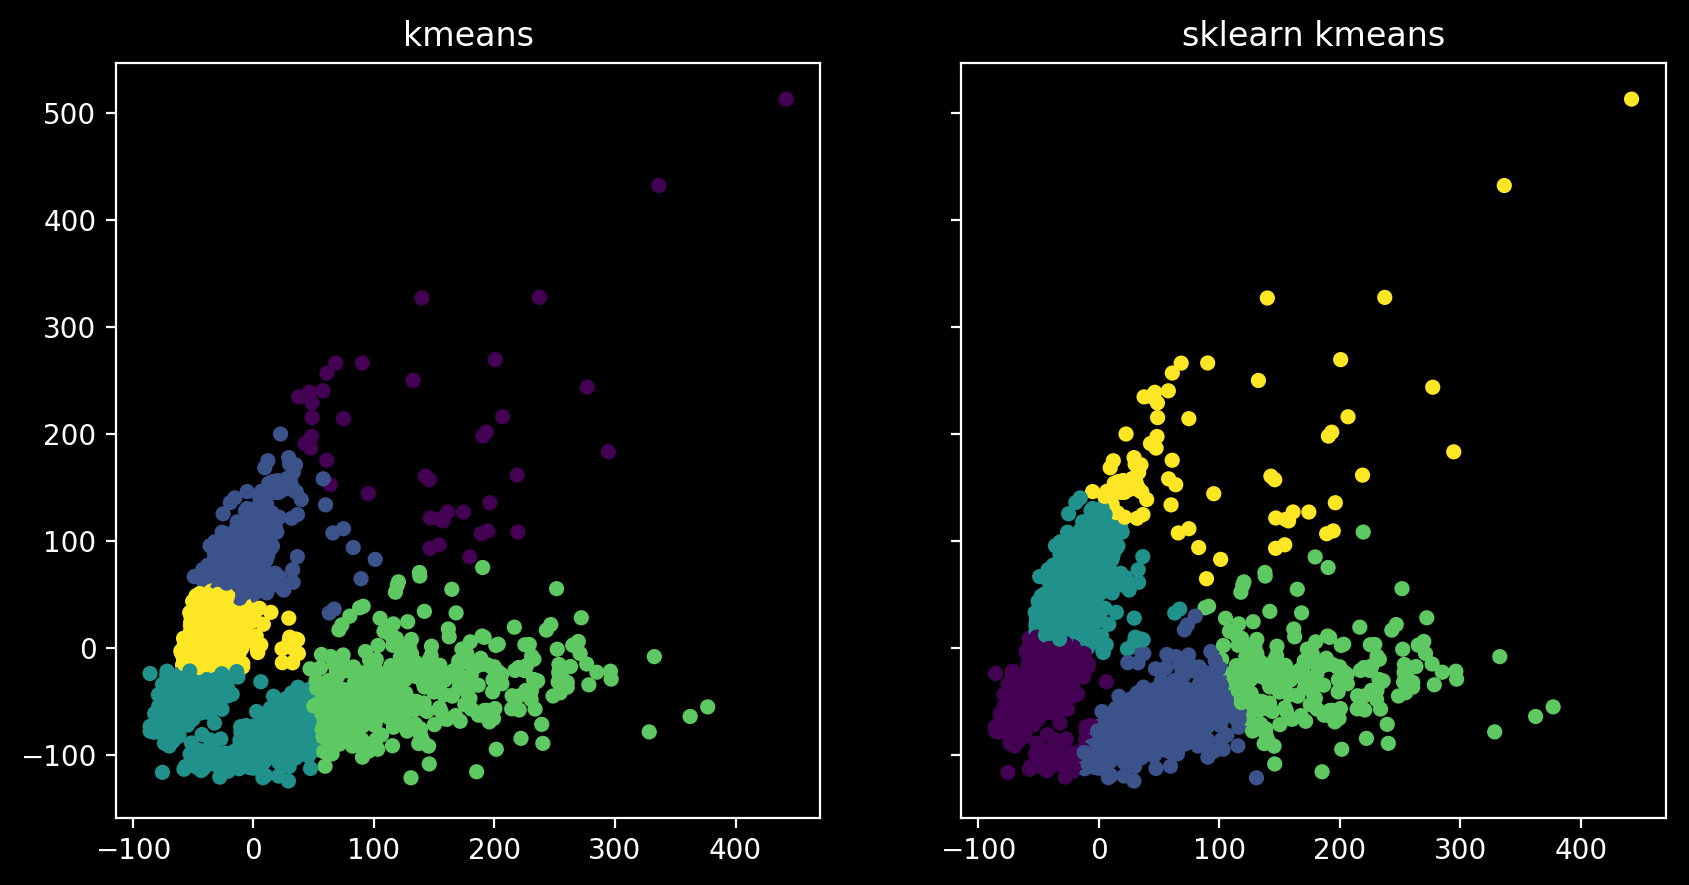

In [28]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        empty_check()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)


Empty cluster! Correcting centroids.
Runtime: 0:00:02.014717
kmeans centroids: [[182.88874817 -24.53409386]
 [130.36091614 198.16094971]
 [-17.86816788  55.53120041]
 [ 58.50764847 -64.98576355]
 [-43.22187805 -27.62013245]]
Runtime: 0:00:00.090786
sklearnkmeans centroids: [[ 52.147705 -68.04191 ]
 [-45.720844 -33.25464 ]
 [ 85.96949  173.40831 ]
 [174.54155  -25.31637 ]
 [-21.4257    46.127094]]


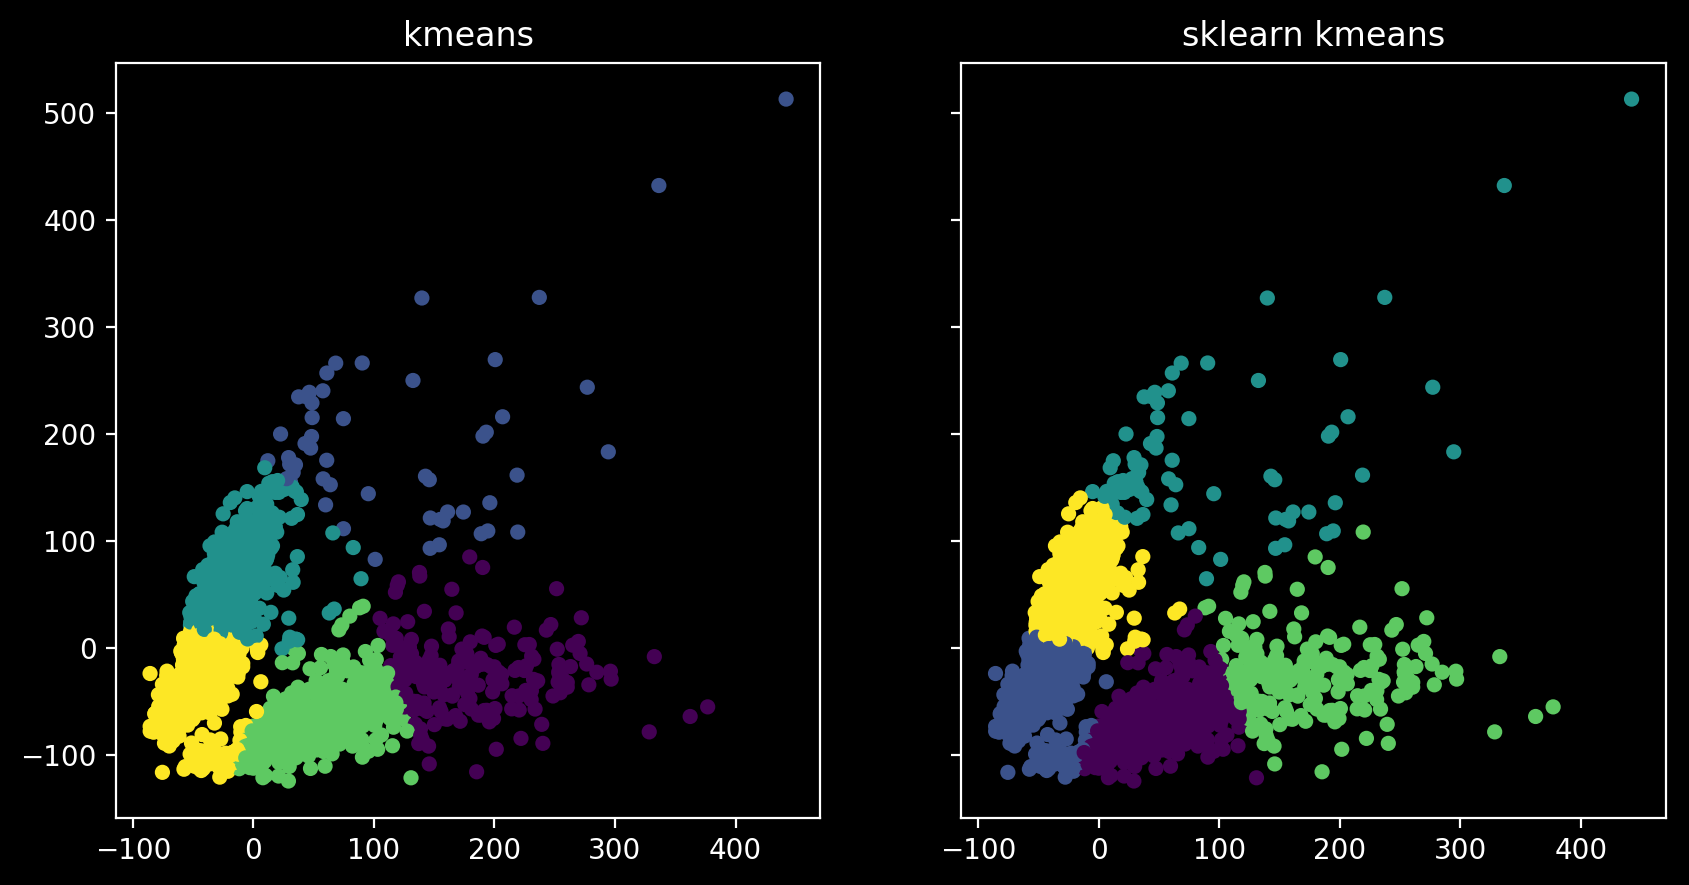

In [29]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1 
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("Runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes, k
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (max(pca_data[:, 1]) - min(pca_data[:, 1]))* np.random.random_sample((k, genes)) + min(pca_data[:, 1])

def assign_centroids():
    global nearest_centroid, patients, k
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])    
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1

def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i+1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        else:
            pass
        i += 1

def dist(patient_point, cluster_number):
    global centroids_array
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number-1, :]
    d = np.linalg.norm(a-b)
    return d
    

def new_centroids():
    global centroids_array
    zeros = np.zeros([patients,1])
    centroids_array = np.empty([0, genes])
    #"Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    #while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1
              

def kmeans(k1, n_iterations):
        global k
        k = k1
        i = 0
        random_start_centroids("randnum")
        assign_centroids()
        empty_check()
        while i<n_iterations:
                new_centroids()
                assign_centroids()
                i+=1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)


# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())


# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
#print(sum(pca.explained_variance_ratio_))
#print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print(runtime_end())


# plotting
fig = pyplot.figure(1, figsize=[10,5], dpi = 200)
plt1, plt2 = fig.subplots(1,2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
print("kmeans centroids:", centroids_array)


#sklearn comparison
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
print("sklearnkmeans centroids:", sklearn_kmeans.cluster_centers_)
